In [1]:
# !pip install pandas
# !pip install numpy
# !pip install datasets
# !pip install scikit-learn
# !pip install matplotlib
# !pip install pymongo
# !pip install pyspark

In [2]:
import pandas as pd
import json
import numpy as np
import time 
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pymongo import MongoClient
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
# Set the ALS hyperparameters
from pyspark.ml.recommendation import ALS
# Import RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator


c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We use SVD factorization matrix beacuse it has only postive values, instead of use LU factorization 

The RMSE basically tells you, on average, how far off your predictions are from the actual values.

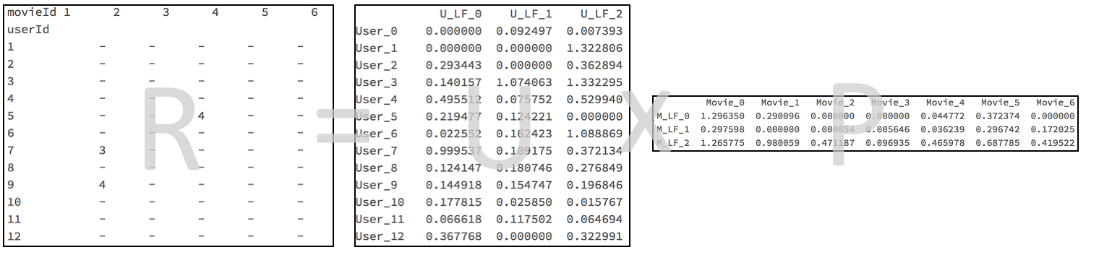

ALS is the algorithm that create the factorization adjusted by RMSE 

## PySpark Env

In [3]:
# Inicia una sesión de Spark
spark = SparkSession.builder \
    .appName("RecommenderEngine") \
    .getOrCreate()

## Classes

In [4]:
class ConnectDB:
    def __init__(self) -> None:
        self.client = client = MongoClient("mongodb://localhost:27017")
        self.db = db = client.massiveData
    
    def create_collection(self,name):
        collection = self.db[name]
        return None

    def get_collection(self,name):
        collection = self.db[name]
        return collection

## Extracting and Preparing the data

If the data has the format :

*    rows -> users
*    columns -> products    
*    cells -> ratings
    
Then you need to proccess the data into row-based raitings

*    columns = `['id_user','id_product','rating']`

Our data is saved in that form in mongoDB, so we are going to query the reviews


In [5]:
db = ConnectDB()

reviews = db.get_collection('reviews')

reviews_query = reviews.find({}, {"_id": 0, "id_user": True, "id_product": True, "rating": True})

ratings = spark.createDataFrame(reviews_query)

# ratings.toPandas().to_csv('./query_reviews.csv')

##### Preparing Data


Now we need to map all the id, both id products and id users because ALS algorithm only recives integers


Create a dataframe called users that contains all the `.distinct()` users from the dataframe and repartition the dataframe into one partition using the `.coalesce(1)` method.

In [6]:
# Get unique users and repartition to 1 partition
users = ratings.select("id_user").distinct().coalesce(1)

# Create a new column of unique integers called "userId" in the users dataframe.
users = users.withColumn("userId", monotonically_increasing_id()).persist()


# Extract the distinct movie id's. Repartition the data to have only one partition.
products = ratings.select("id_product").distinct().coalesce(1) 

# Create a new column of movieId integers. 
products = products.withColumn("productId", monotonically_increasing_id()).persist() 

# Join the ratings, users and products dataframes
products_ratings = ratings.join(users, "id_user", "left").join(products, "id_product", "left")


# Tell Spark to convert the columns to the proper data types
products_ratings = products_ratings.select(products_ratings.userId.cast("integer"), products_ratings.productId.cast("integer"), products_ratings.rating.cast("double"))

products_ratings.show()


+------+---------+------+
|userId|productId|rating|
+------+---------+------+
| 28457|     5373|   5.0|
| 32780|     5373|   5.0|
|  6647|    11568|   5.0|
| 30801|    15923|   3.0|
| 24468|    27601|   5.0|
| 42470|    29003|   5.0|
| 37627|    58185|   4.0|
| 37627|    58185|   4.0|
| 37627|    58185|   4.0|
| 30801|    59724|   5.0|
| 23350|    70579|   5.0|
| 25246|    74355|   1.0|
| 35128|    74555|   5.0|
|  5683|    81673|   5.0|
| 30801|    95857|   5.0|
| 25478|   103574|   1.0|
| 50483|   113319|   5.0|
| 37902|   129330|   5.0|
| 11378|   135657|   4.0|
|  8657|   151226|   1.0|
+------+---------+------+
only showing top 20 rows



##### Calculating Sparsity

The products_ratings dataframe is  99.999196% empty.

In [7]:
# # Count the total number of ratings in the dataset
# numerator = products_ratings.select("rating").count()

# # Count the number of distinct userIds and distinct movieIds
# num_users = products_ratings.select("userId").distinct().count()
# num_products = products_ratings.select("productId").distinct().count()

# # Set the denominator equal to the number of users multiplied by the number of movies
# denominator = num_users * num_products

# # Divide the numerator by the denominator
# sparsity = (1.0 - (numerator * 1.0)/denominator)*100
# print("The products_ratings dataframe is ", "%.6f" % sparsity + "% empty.")

## ALS algorithm

##### Summary of Alternating Least Squares (ALS) Algorithm

ALS is a collaborative filtering algorithm used for recommendation systems. It allows you to choose the number of latent features, referred to as the "rank" hyperparameter, typically denoted by the letter k. The objective is to determine the optimal rank for the data. By experimenting with different numbers of latent features, you can find meaningful groupings or categories of items (e.g., movies) to assess their similarity or differences.

The algorithm iterates back and forth between factor matrices to adjust values and minimize the Root Mean Square Error (RMSE). The number of iterations, or "maxIter," specifies how many times ALS should iterate.

Regularization, represented by the lambda parameter (or "regParam" in PySpark), is added to the error metric to prevent overfitting and ensure the algorithm converges properly.

For explicit ratings, alpha is not used. It's only relevant when working with implicit ratings.

When splitting data into test and train sets, it's crucial to ensure that users have ratings in both sets. Otherwise, ALS cannot make meaningful predictions for those users or calculate an error metric. To address this, the coldStartStrategy is set to "drop," indicating that Spark should not use users with missing ratings in either set to calculate RMSE.

In summary, ALS is a powerful algorithm for collaborative filtering that allows for customization through parameters such as rank, maxIter, and regParam. By fine-tuning these parameters, you can build effective recommendation systems tailored to your specific use case.


*   `rank = N` : Number of latent features
*   `maxIter = 100` : Number of iterations
*   `regParam = .05` : Value to consider if RMSE is converging
*   `alpha = 40` : Only used with implicit ratings
*   `nonnegative = True` : Ensures positive numbers
*   `coldStartStrategy = "drop" ` : Ensures that RMSE is calculated with users that are both in train set and test set
*   `implicitPrefs = False` : Depends on ratings type (in this case explicit)

##### Applying algorithm

In [8]:
# Split the ratings dataframe into training and test data
(training_data, test_data) = products_ratings.randomSplit([0.8, 0.2], seed=42)


als = ALS(userCol="userId", itemCol="productId", ratingCol="rating", 
          coldStartStrategy="drop", nonnegative =True, implicitPrefs = False)


# Tell Spark what values to try for each hyperparameter
param_grid = ParamGridBuilder().addGrid(als.rank, [5, 120]).addGrid(als.maxIter, [100, 250]).addGrid(als.regParam, [.05, .1]).build()


# Tell Spark how to evaluate model performance           
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")


# Build cross validation step using CrossValidator 
cv = CrossValidator(estimator = als,estimatorParamMaps = param_grid,evaluator = evaluator,numFolds = 5)


# Run the cv on the training data                    
model = cv.fit(training_data)                    

# Extract best combination of values from cross validation
best_model = model.bestModel

# Generate test set predictions and evaluate using RMSE
predictions = best_model.transform(test_data)
rmse = evaluator.evaluate(predictions)



# # Print evaluation metrics and model parameters
print ("**Best Model**")
print(best_model)
# print ("RMSE = "), rmse
# print ("  Rank: "), best_model
# print ("  MaxIter: "), best_model._java_obj.parent().getMaxIter()
# print ("  RegParam: "), best_model._java_obj.parent().getRegParam()


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52329)
Traceback (most recent call last):
  File "c:\ProgramData\miniconda3\Lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\ProgramData\miniconda3\Lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "c:\ProgramData\miniconda3\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\ProgramData\miniconda3\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "C:\Users\aleks\AppData\Roaming\Python\Python311\site-packages\pyspark\accumulators.py", line 295, in handle
    poll(accum_updates)
  File "C:\Users\aleks\AppData\Roaming\Python\Python311\site-packages\pyspark\accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "C:

ConnectionRefusedError: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión

Now that you know how to build a model and generate predictions, and have an evaluator to tell us how well it predicts ratings, we can calculate the RMSE to see how well an ALS model performed. We'll use the `RegressionEvaluator` with `rmse` as the metric

In [ ]:

# Complete the evaluator code
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Extract the 3 parameters
print(evaluator.getMetricName())
print(evaluator.getLabelCol())
print(evaluator.getPredictionCol())


# Evaluate the "test_predictions" dataframe
RMSE = evaluator.evaluate(test_predictions)

# Print the RMSE
print (RMSE)

rmse
rating
prediction
2.050313048607636


This RMSE means that on average, the model's test predictions are about 2.05 off from the true values. This is not a very good model

In [ ]:
# End spark session
spark.stop()

NameError: name 'spark' is not defined